# Simulated Annealing for the Travelling Salesman Problem

In [1]:
import pandas as pd
import math
import random
import numpy as np
import copy
import collections as coll
import matplotlib.pyplot as plt

### Instances

#### Test instance

In [2]:
distance_matrix = np.array([[0, 10, 10 * np.sqrt(2), 10],
                            [10, 0, 10, 10 * np.sqrt(2)],
                            [10 * np.sqrt(2), 10, 0, 10],
                            [10, 10 * np.sqrt(2), 10, 0]])

distance_matrix

array([[ 0.        , 10.        , 14.14213562, 10.        ],
       [10.        ,  0.        , 10.        , 14.14213562],
       [14.14213562, 10.        ,  0.        , 10.        ],
       [10.        , 14.14213562, 10.        ,  0.        ]])

### Classes

In [3]:
class Instance():
    def __init__(self):
        self.distances = None

instance = Instance()
instance.distances = distance_matrix

In [4]:
class Sol():
    def __init__(self):
        self.matrix = None
        self.obj = None
        self.best_sol = None
        self.bestObj = None
        self.routes = None

### Required functions

In [5]:
def greaterZero(n):
    return n > 0

In [6]:
def powerset(listsub):
    subsets = []
    for i in range(2**len(listsub)):
        subset = []
        for k in range(len(listsub)):
            if i & 1 << k:
                subset.append(listsub[k])
                subsets.append(subset)

    return [x for x in sorted(sorted(subsets[1:]), key=len) if len(x) >= 2]

In [7]:
def genInitialSol(instance):
    "This function provides a random initialization (random seed) for the problem variables"
    distance_matrix = instance.distances
    N = distance_matrix.shape[0]
    init_sol = np.zeros((N, N), dtype=int)
    
    random.seed()
    for i in range(N):
        for j in range(N):
            # if i != j:
            #     init_sol[i, j] = int(round(random.random()))
            init_sol[i, j] = int(round(random.random()))
    
    return init_sol

In [8]:
def plotObj(obj_list):    
    plt.rcParams['axes.unicode_minus'] = False   # Show minus sign
    plt.plot(np.arange(1, len(obj_list)+1), obj_list)
    plt.xlabel('Iterations')
    plt.ylabel('Obj Value')
    plt.grid()
    plt.xlim(1, len(obj_list)+1)
    plt.show()

### Definition of the QUBO objective function

In [9]:
def calObj_QUBO(solution, A, instance, evaluating_distances):

    sol = solution.matrix
    N = sol.shape[0]
    dist_mat = instance.distances
    
    vec_X = sol.flatten('F')

    # Computing total distance from a given solution
    P = np.identity(N)
    P = np.roll(P, 1, axis=0)
    H_B = vec_X.T @ np.kron(P.T, dist_mat) @ vec_X

    # From each costumer, only depart just one single vehicle
    all_ones = np.ones((N, N))
    identity = np.identity(N)
    Q_C = np.kron(all_ones, identity) + np.kron(identity, all_ones) - 4 * np.kron(identity, identity)
    H_A = vec_X.T @ Q_C @ vec_X + 2 * N
   
    obj_QUBO = evaluating_distances * H_B + A * H_A

    return obj_QUBO

### Tests

In [11]:
A = 1
evaluating_distances = True
sol = Sol()
sol.matrix = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

sol.matrix = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

print(np.shape(sol.matrix))
sol.obj = calObj_QUBO(sol, A, instance, evaluating_distances)
sol.best_sol = sol.matrix
sol.bestObj = sol.obj

print(sol.matrix)
print(sol.obj)

(4, 4)
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
48.2842712474619


### Actions

#### This action compares through all the neighbours

In [13]:
def action2(solution, A, instance, evaluating_distances):
    LocalMinimumFlag = False
    solution_iter = Sol()    
    list_better_neighbours = []
    # sol = solution.matrix
    # sol.flags.writeable = False
    
    # print(solution.matrix)
    # print(solution.obj)
    for i in range(solution.matrix.shape[0]):
        for j in range(solution.matrix.shape[1]):            
            # solution_iter.matrix = sol
            solution_iter = copy.deepcopy(solution)
            # if i != j:
            #     solution_iter.matrix[i, j] = (solution_iter.matrix[i, j]+1)%2
            solution_iter.matrix[i, j] = (solution_iter.matrix[i, j]+1)%2
            solution_iter.obj = calObj_QUBO(
                solution_iter, A, instance, evaluating_distances)
            # print(i, j, solution_iter.matrix, solution_iter.obj)
            if solution_iter.obj < solution.obj:
                list_better_neighbours.append([[i, j], solution_iter.obj])
    # print(solution.matrix)
    
    # print(list_better_neighbours)
    if len(list_better_neighbours) != 0:
        list_better_neighboursObj = [neighbour[1] for neighbour in list_better_neighbours]
        min_value = min(list_better_neighboursObj)
        position = list_better_neighbours[list_better_neighboursObj.index(min_value)][0]
        # print(position)
        solution.matrix[position[0], position[1]] = (solution.matrix[position[0], position[1]]+1)%2
        # print(solution.matrix)
        solution.obj = calObj_QUBO(solution, A, instance, evaluating_distances)
    else:
        LocalMinimumFlag = True       
    
    return LocalMinimumFlag, solution.matrix

In [14]:
A = 1
evaluating_distances = True
sol = Sol()
sol.matrix = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [0, 0, 0, 0],
    [1, 0, 0, 0]
])

# sol.matrix = np.array([
#     [0, 0, 0, 1],
#     [1, 0, 0, 0],
#     [0, 1, 0, 0],
#     [0, 0, 1, 0]
# ])

# print(np.shape(sol.matrix))
sol.obj = calObj_QUBO(sol, A, instance, evaluating_distances)
sol.best_sol = sol.matrix
sol.bestObj = sol.obj

print(sol.matrix)
print(sol.obj)

sol.matrix = action2(sol, A, instance, True)[1]
sol.obj = calObj_QUBO(sol, A, instance, evaluating_distances)
sol.best_sol = sol.matrix
sol.bestObj = sol.obj

print(sol.matrix)
print(sol.obj)

[[0 1 1 0]
 [1 0 1 1]
 [0 0 0 0]
 [1 0 0 0]]
62.14213562373095
[[0 0 1 0]
 [1 0 1 1]
 [0 0 0 0]
 [1 0 0 0]]
32.14213562373095


### SA algorithm

In [16]:
def run2(instance, A, evaluating_distances, T0, Tf, deltaT):
    history_best_obj = []

    sol = Sol()
    sol.matrix = genInitialSol(instance)    
    sol.obj = calObj_QUBO(sol, A, instance, evaluating_distances)
    sol.best_sol = sol.matrix
    sol.bestObj = sol.obj

    # print(sol.matrix)
    # print(sol.obj)

    LocalMinimumFlag = False

    Tk = T0    
    while Tk >= Tf:
        new_sol = Sol()
        LocalMinimumFlag, new_sol.matrix = action2(
            sol, A, instance, evaluating_distances)
        # print('')
        # print(LocalMinimumFlag)
        # print(new_sol.matrix)
        if LocalMinimumFlag:
            new_sol.matrix = genInitialSol(instance)

        new_sol.obj = calObj_QUBO(
            new_sol, A, instance, evaluating_distances)
        
        # print('')
        # print(new_sol.matrix)
        # print(new_sol.obj)
        
        # introduce initial values of the constraints
        delta_obj = new_sol.obj - sol.obj

        if delta_obj < 0 or math.exp(-delta_obj/Tk) > random.random():
            # sol = copy.deepcopy(new_sol)
            sol.matrix = new_sol.matrix
            sol.obj = new_sol.obj
        if sol.obj < sol.bestObj:
            sol.best_sol = sol.matrix
            sol.bestObj = sol.obj

        if Tk < 1:
            Tk = Tk * deltaT
        else:
            Tk = Tk - deltaT

        history_best_obj.append(sol.bestObj)
        # print(sol.matrix)
        print("temperature: %s, local obj: %s, best obj: %s" %
              (Tk, sol.obj, sol.bestObj))
        
    print("temperature: %s, local obj: %s, best obj: %s" %(Tk, sol.obj, sol.bestObj))
    plotObj(history_best_obj)
    print('The best solution reached is:')
    print(sol.best_sol)
    print('And its Objective function value is:')
    print(sol.bestObj)
    return True

temperature: 299.1, local obj: 740.7106781186548, best obj: 740.7106781186548
temperature: 298.20000000000005, local obj: 430.71067811865476, best obj: 430.71067811865476
temperature: 297.30000000000007, local obj: 282.42640687119285, best obj: 282.42640687119285
temperature: 296.4000000000001, local obj: 158.2842712474619, best obj: 158.2842712474619
temperature: 295.5000000000001, local obj: 134.14213562373095, best obj: 134.14213562373095
temperature: 294.60000000000014, local obj: 124.14213562373095, best obj: 124.14213562373095
temperature: 293.70000000000016, local obj: 48.2842712474619, best obj: 48.2842712474619
temperature: 292.8000000000002, local obj: 830.7106781186548, best obj: 48.2842712474619
temperature: 291.9000000000002, local obj: 506.5685424949238, best obj: 48.2842712474619
temperature: 291.0000000000002, local obj: 282.42640687119285, best obj: 48.2842712474619
temperature: 290.10000000000025, local obj: 158.2842712474619, best obj: 48.2842712474619
temperature: 2

temperature: 134.40000000000032, local obj: 210.0, best obj: 40.0
temperature: 133.5000000000003, local obj: 134.14213562373095, best obj: 40.0
temperature: 132.6000000000003, local obj: 120.0, best obj: 40.0
temperature: 131.7000000000003, local obj: 40.0, best obj: 40.0
temperature: 130.8000000000003, local obj: 40.0, best obj: 40.0
temperature: 129.9000000000003, local obj: 40.0, best obj: 40.0
temperature: 129.00000000000028, local obj: 40.0, best obj: 40.0
temperature: 128.10000000000028, local obj: 40.0, best obj: 40.0
temperature: 127.20000000000027, local obj: 40.0, best obj: 40.0
temperature: 126.30000000000027, local obj: 40.0, best obj: 40.0
temperature: 125.40000000000026, local obj: 40.0, best obj: 40.0
temperature: 124.50000000000026, local obj: 40.0, best obj: 40.0
temperature: 123.60000000000025, local obj: 40.0, best obj: 40.0
temperature: 122.70000000000024, local obj: 40.0, best obj: 40.0
temperature: 121.80000000000024, local obj: 40.0, best obj: 40.0
temperature: 1

temperature: 0.24299999999995625, local obj: 40.0, best obj: 40.0
temperature: 0.21869999999996062, local obj: 40.0, best obj: 40.0
temperature: 0.19682999999996456, local obj: 40.0, best obj: 40.0
temperature: 0.1771469999999681, local obj: 40.0, best obj: 40.0
temperature: 0.1594322999999713, local obj: 40.0, best obj: 40.0
temperature: 0.14348906999997418, local obj: 40.0, best obj: 40.0
temperature: 0.12914016299997677, local obj: 40.0, best obj: 40.0
temperature: 0.11622614669997909, local obj: 40.0, best obj: 40.0
temperature: 0.10460353202998118, local obj: 40.0, best obj: 40.0
temperature: 0.09414317882698307, local obj: 40.0, best obj: 40.0
temperature: 0.08472886094428476, local obj: 40.0, best obj: 40.0
temperature: 0.07625597484985629, local obj: 40.0, best obj: 40.0
temperature: 0.06863037736487065, local obj: 40.0, best obj: 40.0
temperature: 0.06176733962838359, local obj: 40.0, best obj: 40.0
temperature: 0.05559060566554523, local obj: 40.0, best obj: 40.0
temperature:

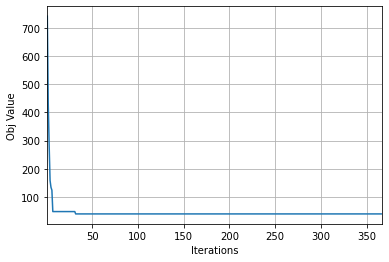

The best solution reached is:
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]
And its Objective function value is:
40.0


In [17]:
if __name__ == '__main__':
    relaxation_parameter = 50
    evaluating_distances = True
    run2(instance, relaxation_parameter, evaluating_distances, T0=300, Tf=0.01, deltaT=0.9)